In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
import seaborn as sns

In [2]:
def get_month(time):
    '''
    Rounds a datetime to a month

            Parameters:
                    time (Timestamp): Any datetime

            Returns:
                    time_month (int): month of input datetime
    '''
    pu_datetime = datetime.fromisoformat(str(time))
    return pu_datetime.month

In [3]:
# read in taxi and airbnb data
taxi_data_df = pd.read_csv('./processed_data/full_taxi_data_df_clean.csv')
airbnb_data_df = pd.read_csv('./processed_data/zone_airbnb_info.csv')

In [4]:
# extract the factors we need from the taxi data

TAXI_PREDICTIVE_FACTORS = [
    'pickup_datetime', 
    'pu_hour', 
    'PULocationID',
    'DOLocationID',
    'trip_duration', 
    'profit_label'
    ]

predictive_factors_df = taxi_data_df[TAXI_PREDICTIVE_FACTORS].copy()

In [5]:
# get int of month of each trip
predictive_factors_df['month'] = predictive_factors_df.apply(lambda x: get_month(x['pickup_datetime']), axis=1)

# get int of pick up hour for each trip
predictive_factors_df['pu_hour'] = predictive_factors_df.apply(lambda x: int(x['pu_hour'].split(':')[0]), axis=1)

# we now dont need the pick up datetime
predictive_factors_df.drop('pickup_datetime', axis=1, inplace=True)

In [6]:
# extract the columns we need from the airbnb data
AIRBNB_PREDICTIVE_FACTORS = [
    'zone_y', 
    'counts', 
    'price', 
    'minimum_nights', 
    'number_of_reviews', 
    'reviews_per_month'
    ]
predictive_factors_airbnb = airbnb_data_df[AIRBNB_PREDICTIVE_FACTORS].copy()
predictive_factors_airbnb.set_index('zone_y', inplace=True)

In [7]:
# seperate our data into two for analysis - data with and data without AirBnB data
data_w_o_airbnb = predictive_factors_df

In [8]:
# add taxi data factors with airbnb data from trip pick up location
data_w_airbnb = pd.merge(data_w_o_airbnb, predictive_factors_airbnb, left_on='PULocationID', right_index=True)

In [9]:
# change column names to distinguish between Airbnb data from trip's pick up and drop off location
column_changes_PU = {
    'counts': 'PU_count',
    'price': 'PU_price',
    'minimum_nights': 'PU_min_nights',
    'number_of_reviews': 'PU_number_of_reviews',
    'reviews_per_month': 'PU_reviews_per_month'
}

data_w_airbnb.rename(columns=column_changes_PU, inplace=True)

In [10]:
# add taxi data factors with airbnb data from trip drop off location
data_w_airbnb = pd.merge(data_w_airbnb, predictive_factors_airbnb, left_on='DOLocationID', right_index=True)

In [11]:
# change column names to distinguish between Airbnb data from trip's pick up and drop off location
column_changes_DO = {
    'counts': 'DO_count',
    'price': 'DO_price',
    'minimumnights': 'DO_min_nights',
    'number_of_reviews': 'DO_number_of_reviews',
    'reviews_per_month': 'DO_reviews_per_month'
}

data_w_airbnb.rename(columns=column_changes_DO, inplace=True)

In [12]:
# create dict of zones to borough ID
zone_lookup_df = pd.read_csv('data/taxi+_zone_lookup.csv')
zone_lookup_dict = dict(zip(zone_lookup_df['LocationID'],zone_lookup_df['Borough_ID']))

# change zone ID to borough ID
data_w_airbnb['PULocationID'] = data_w_airbnb['PULocationID'].map(zone_lookup_dict)
data_w_airbnb['DOLocationID'] = data_w_airbnb['DOLocationID'].map(zone_lookup_dict)
data_w_o_airbnb['PULocationID'] = data_w_o_airbnb['PULocationID'].map(zone_lookup_dict)
data_w_o_airbnb['DOLocationID'] = data_w_o_airbnb['DOLocationID'].map(zone_lookup_dict)

# one hot encode Borough ID
data_w_o_airbnb = pd.concat([data_w_o_airbnb,
                        pd.get_dummies(data_w_o_airbnb['PULocationID'], prefix='PU_borough'), 
                        pd.get_dummies(data_w_o_airbnb['DOLocationID'], prefix='DO_borough')], 
                        axis=1)

data_w_airbnb = pd.concat([data_w_airbnb,
                        pd.get_dummies(data_w_airbnb['PULocationID'], prefix='PU_borough'), 
                        pd.get_dummies(data_w_airbnb['DOLocationID'], prefix='DO_borough')], 
                        axis=1)

# no longer need location ID
data_w_o_airbnb.drop(['PULocationID', 'DOLocationID'], axis=1, inplace=True)
data_w_airbnb.drop(['PULocationID', 'DOLocationID'], axis=1, inplace=True)

In [13]:
# split up into Train and Test, 
# train is months 5 and 6
# test is month 7

## WITH AIRBNB
train_data_df_airbnb = data_w_airbnb.loc[data_w_airbnb['month'].isin([5,6])]
print(train_data_df_airbnb.shape)
test_data_df_airbnb = data_w_airbnb.loc[data_w_airbnb['month'] == 7]
print(test_data_df_airbnb.shape)

# WITHOUT AIRBNB
train_data_df_base = data_w_o_airbnb.loc[data_w_o_airbnb['month'].isin([5,6])]
print(train_data_df_base.shape)
test_data_df_base = data_w_o_airbnb.loc[data_w_o_airbnb['month'] == 7]
print(test_data_df_base.shape)

(8679213, 24)
(3666051, 24)
(9664405, 16)
(4076388, 16)


In [14]:
# AIRBNB
X_train_AB = train_data_df_airbnb.drop('profit_label', axis=1)
X_test_AB = test_data_df_airbnb.drop('profit_label', axis=1)
Y_train_AB = train_data_df_airbnb['profit_label']
Y_test_AB = test_data_df_airbnb['profit_label']

# WITHOUT AIRBNB

X_train_base = train_data_df_base.drop('profit_label', axis=1)
X_test_base = test_data_df_base.drop('profit_label', axis=1)
Y_train_base = train_data_df_base['profit_label']
Y_test_base = test_data_df_base['profit_label']




In [15]:
# firstly, lets scale the data

scaler = StandardScaler()

X_train_AB = scaler.fit_transform(X_train_AB)
X_test_AB = scaler.transform(X_test_AB)

X_train_base = scaler.fit_transform(X_train_base)
X_test_base = scaler.transform(X_test_base)

In [16]:
# now apply PCA
pca = PCA(n_components = 0.95)


X_train_AB = pca.fit_transform(X_train_AB)
X_test_AB = pca.transform(X_test_AB)

X_train_base = pca.fit_transform(X_train_base)
X_test_base = pca.transform(X_test_base)

Accuracy (with AirBnb): 0.559243993059562
Accuracy (without AirBnb): 0.5232239914355552


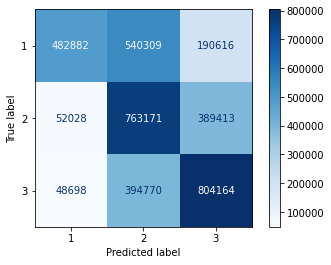

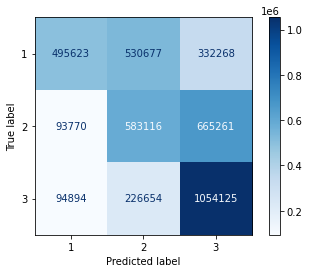

In [17]:
# NAIVE BAYES


# with AirBNB
nbG = GaussianNB()
nbG.fit(X_train_AB, Y_train_AB)
y_pred = nbG.predict(X_test_AB)
print("Accuracy (with AirBnb):",metrics.accuracy_score(Y_test_AB, y_pred))
plot_confusion_matrix(nbG, X_test_AB, Y_test_AB, cmap=plt.cm.Blues, values_format = '')

# without AirBNB
nbG = GaussianNB()
nbG.fit(X_train_base, Y_train_base)
y_pred = nbG.predict(X_test_base)
print("Accuracy (without AirBnb):",metrics.accuracy_score(Y_test_base, y_pred))
plot_confusion_matrix(nbG, X_test_base, Y_test_base, cmap=plt.cm.Blues, values_format = '')



In [18]:
# DECISION TREE

dt_accuracy_airbnb = []
dt_accuracy_no_airbnb = []
for i in range(3,20):    
    
    clf = DecisionTreeClassifier(max_depth = i)
    clf = clf.fit(X_train_AB,Y_train_AB)
    y_pred = clf.predict(X_test_AB)
    dt_accuracy_airbnb.append(metrics.accuracy_score(Y_test_AB, y_pred))
    print(f'Accuracy with {i} depth (AirBnB):{metrics.accuracy_score(Y_test_AB, y_pred)}')

    clf = DecisionTreeClassifier(max_depth = i)
    clf = clf.fit(X_train_base,Y_train_base)
    y_pred = clf.predict(X_test_base)
    dt_accuracy_no_airbnb.append(metrics.accuracy_score(Y_test_base, y_pred))
    print(f'Accuracy with {i} depth (No AirBnB):{metrics.accuracy_score(Y_test_base, y_pred)}')

    

In [ ]:
# with AirBNB
dt1 = DecisionTreeClassifier(max_depth=25)
dt1.fit(X_train_AB, Y_train_AB)
y_pred = dt1.predict(X_test_AB)
print("Accuracy (with AirBnb):",metrics.accuracy_score(Y_test_AB, y_pred))
plot_confusion_matrix(dt1, X_test_AB, Y_test_AB, cmap=plt.cm.Blues, values_format = '')


In [ ]:
depth = range(1,16)
sns.set_style('darkgrid')
tree_graph_dict = {
    'Depth': depth, 
    'DT Accuracy with AirBnB Data': dt_accuracy_airbnb, 
    'DT Accuracy without AirBnB Data': dt_accuracy_no_airbnb
}

tree_graph_df = pd.DataFrame(tree_graph_dict)
tree_graph_df
sns.lineplot(x='Depth',
            y='value',
            markers=True,
            hue='variable',
            data=pd.melt(tree_graph_df, ['Depth']))



In [ ]:
# LOGISTIC REGRESSION
# with AirBNB
lgr = LogisticRegression(solver = 'saga', multi_class="multinomial", max_iter=50)
lgr.fit(X_train_AB, Y_train_AB)
y_pred = lgr.predict(X_test_AB)
print("Accuracy (with AirBnb):",metrics.accuracy_score(Y_test_AB, y_pred))

In [ ]:

# without AirBNB
lgr = LogisticRegression(solver = 'saga', multi_class="multinomial", max_iter=100)
lgr.fit(X_train_base, Y_train_base)
y_pred = lgr.predict(X_test_base)
print("Accuracy (without AirBnb):",metrics.accuracy_score(Y_test_base, y_pred))





In [ ]:
# visualise logistic regression
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='auto', solver='liblinear')

# fit and transform data
X_train_pca = pca.fit_transform(X_train_AB)
X_test_pca = pca.transform(X_test_AB)
lr.fit(X_train_pca, Y_train_AB)

In [ ]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl) # plot decision regions for training set


plot_decision_regions(X_train_pca, Y_train_AB, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper left')
plt.show()